In [1]:
import numpy  as np
dtrajs = [traj for traj in np.load('contacts-results/src_10471_dtrajs.npy')]

In [2]:
import pyemma
from msmbuilder.msm import MarkovStateModel

In [3]:
%%time
msm = pyemma.msm.estimate_markov_model(dtrajs, 50)

CPU times: user 2min 36s, sys: 208 ms, total: 2min 36s
Wall time: 2min 36s


/Users/joshuafass/anaconda/lib/python2.7/site-packages/msmtools/estimation/api.py:941: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  T = sparse.mle_trev.mle_trev(C, **kwargs)


In [4]:
np.trace(msm.P), len(msm.P), np.trace(msm.P) / len(msm.P)

(625.4279889533766, 683, 0.91570715805765246)

In [5]:
%%time
# let's coarse-grain to 20 states
hmm = pyemma.msm.estimate_hidden_markov_model(dtrajs, 20, lag=50, maxit=1)

CPU times: user 1min, sys: 2.51 s, total: 1min 3s
Wall time: 59.3 s


In [6]:
def crisp_assign_using_hmm(i, hmm):
    ''' gets a fixed mapping from microstates to macrostates, using hmm observation matrix '''
    return np.argmax(hmm.observation_probabilities[:,i])

assignments = np.array([crisp_assign_using_hmm(i, hmm) for i in range(len(set(np.hstack(dtrajs))))])

In [7]:
# apply this crisp mapping to our trajectories
cg_dtrajs = [np.array([assignments[i] for i in dtraj]) for dtraj in dtrajs]

In [8]:
# m = the number of propagator eigenfunctions to look at in GMRQ
# --> how do we choose this?
m = 5
lag = 50

from sklearn.cross_validation import ShuffleSplit
from tqdm import tqdm

def shuffle_split_gmrq(dtrajs, m, lag):
    # construct a bunch of shuffle-split partitions (n_iter of them), each with a 50:50 split between training and validation data
    shuffle_split = ShuffleSplit(len(dtrajs), n_iter=100, test_size=0.5, random_state=0)

    # where we'll store results
    train_scores = []
    val_scores = []
    msms = []
    i_s = []

    # iterate over all splits
    for i,(train, validate) in enumerate(tqdm(shuffle_split)):
        try:
            # collect all the dtrajs into the current train vs. validation split
            train_dtrajs = [dtrajs[i] for i in train]
            val_dtrajs = [dtrajs[i] for i in validate]

            # parameterize an MSM
            msm = MarkovStateModel(lag_time = lag, n_timescales = m, verbose=False)
            msm.fit(train_dtrajs)

            msms.append(msm)
            train = msm.score_
            val = msm.score(val_dtrajs)

            train_scores.append(train)
            val_scores.append(val)
            i_s.append(i)

        except:
            # sometimes evaluating the validation score fails for unclear reasons
            print('Something went wrong!')
            pass

    print('Train scores (mean, stdev):',np.mean(train_scores),np.std(train_scores))
    print('Validation scores (mean, stdev):',np.mean(val_scores),np.std(val_scores))
    
    return train_scores, val_scores
    
train_scores, val_scores = shuffle_split_gmrq(cg_dtrajs, 5, 50)

100%|██████████| 100/100 [00:09<00:00, 10.31it/s]

('Train scores (mean, stdev):', 5.9447876887703659, 0.0081239325159296449)
('Validation scores (mean, stdev):', 5.8436842399000239, 0.090477659941281097)


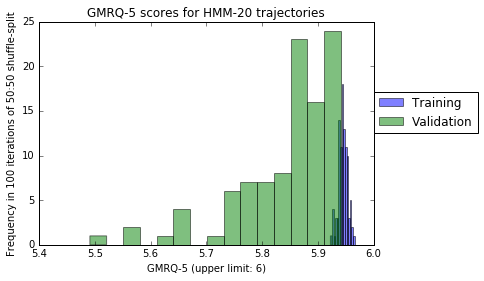

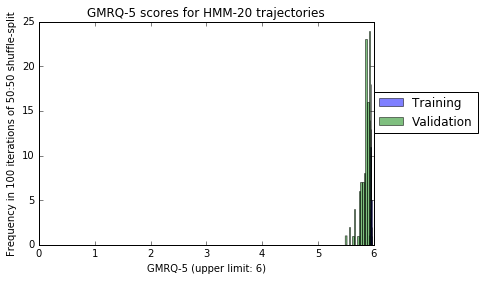

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(train_scores, val_scores, m, name):
    
    title = 'GMRQ-{0} scores for {1} trajectories'.format(m, name)
    xlabel = 'GMRQ-{0} (upper limit: {1})'.format(m, m + 1)
    ylabel = 'Frequency in 100 iterations of 50:50 shuffle-split'

    # zoomed in histogram
    plt.figure()
    plt.hist(train_scores, label='Training', alpha=0.5, bins=15)
    plt.hist(val_scores, label='Validation', alpha=0.5, bins=15)
    plt.legend(loc=(1,0.5))
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # full x range
    plt.figure()
    plt.hist(train_scores, label='Training', alpha=0.5, bins=15)
    plt.hist(val_scores, label='Validation', alpha=0.5, bins=15)
    plt.legend(loc=(1,0.5))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, m + 1)
    
plot(train_scores, val_scores, m, 'HMM-20')

In [10]:
# plot train and test gmrq, w error bars

  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 1.9941467109366504, 0.0020631377932754857)
('Validation scores (mean, stdev):', 1.9740570475231525, 0.036382263823011463)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 2.9852839489474805, 0.0033685193173508014)
('Validation scores (mean, stdev):', 2.9521121443549907, 0.046678551858968631)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 3.9740793129542471, 0.0045717808350004153)
('Validation scores (mean, stdev):', 3.9170252849130192, 0.058511000993010417)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 4.9606472016284915, 0.0061793252058221313)
('Validation scores (mean, stdev):', 4.8811691727239896, 0.079528012443668278)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 5.9447876887703659, 0.0081239325159296449)
('Validation scores (mean, stdev):', 5.8436842399000239, 0.090477659941280819)


100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


('Train scores (mean, stdev):', 6.9264240436561408, 0.010529501666027232)
('Validation scores (mean, stdev):', 6.7968544331123448, 0.11269583153036984)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 7.9052329548096303, 0.01321451116303006)
('Validation scores (mean, stdev):', 7.7320842057927317, 0.16344570549550297)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 8.8808329872732514, 0.016458043685275613)
('Validation scores (mean, stdev):', 8.6729892612703026, 0.17850255814326751)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 9.8531508425915053, 0.020171807200950347)
('Validation scores (mean, stdev):', 9.6103412201110565, 0.19073212747114393)


100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


('Train scores (mean, stdev):', 10.821506010217526, 0.024960962890289689)
('Validation scores (mean, stdev):', 10.529180979196678, 0.20249622202276824)


100%|██████████| 100/100 [00:09<00:00, 10.54it/s]
/Users/joshuafass/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 11.784643225386517, 0.031934095895717163)
('Validation scores (mean, stdev):', 11.441453457126769, 0.2131637748449092)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 12.740126295407554, 0.040449515278740016)
('Validation scores (mean, stdev):', 12.345369304538611, 0.24501486501159858)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 13.685523607849115, 0.052478304298252891)
('Validation scores (mean, stdev):', 13.261820133763388, 0.27234774445853699)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 14.615854410499141, 0.068514168836207451)
('Validation scores (mean, stdev):', 14.179482807004383, 0.29500623816129834)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 15.524002993778577, 0.09023933332161703)
('Validation scores (mean, stdev):', 15.073588765898659, 0.30643447468750179)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 16.401039056640968, 0.12509740967401062)
('Validation scores (mean, stdev):', 15.946687357373785, 0.32522685520653261)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 17.234279833042049, 0.17470444414239605)
('Validation scores (mean, stdev):', 16.827111732233778, 0.35024557257839378)


  0%|          | 0/100 [00:00<?, ?it/s]

('Train scores (mean, stdev):', 17.992468463496269, 0.25700548441801152)
('Validation scores (mean, stdev):', 17.718366497422018, 0.36737558561864248)


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


('Train scores (mean, stdev):', 18.607166734995214, 0.35297893638844741)
('Validation scores (mean, stdev):', 18.638609257389348, 0.38630685872594533)


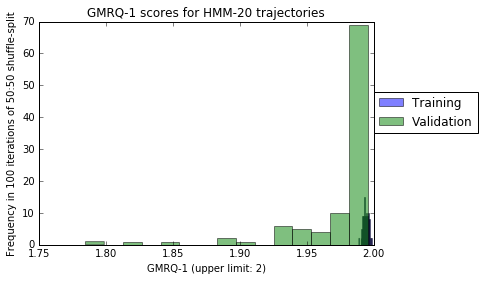

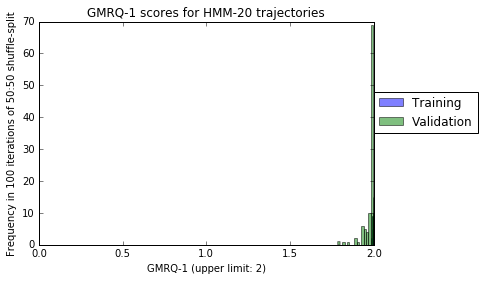

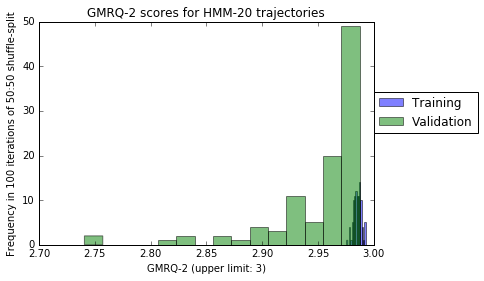

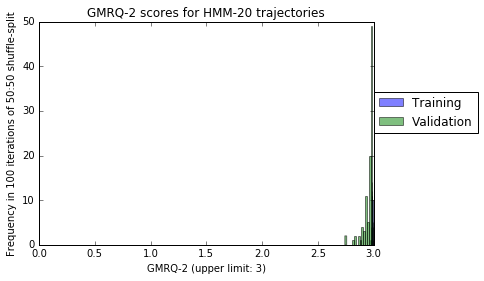

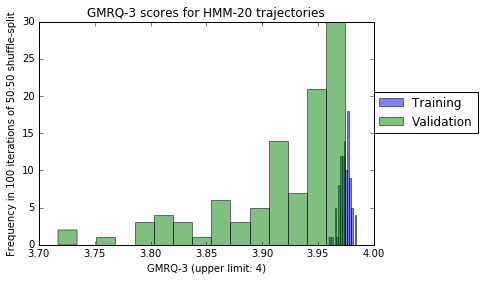

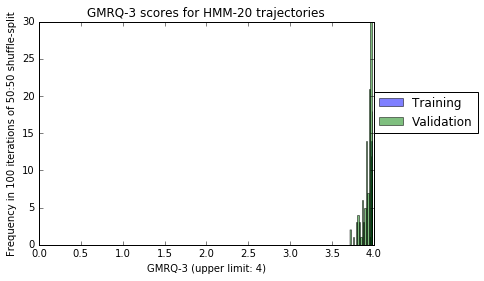

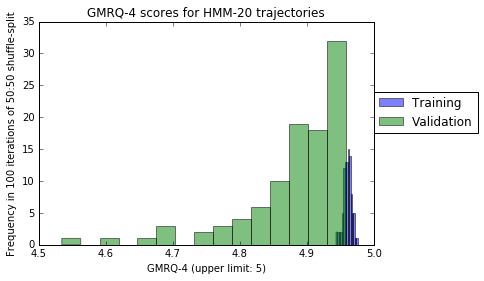

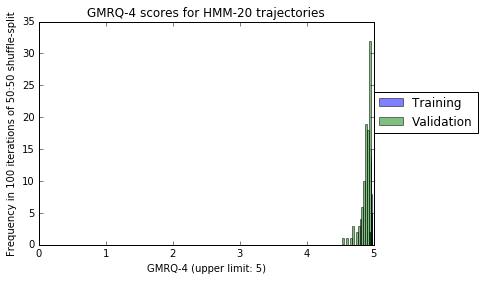

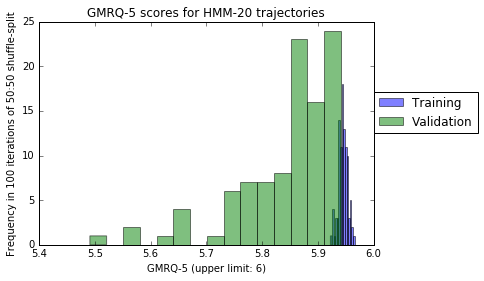

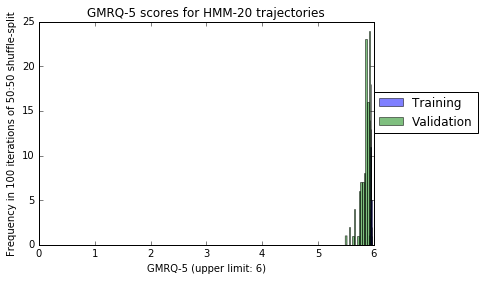

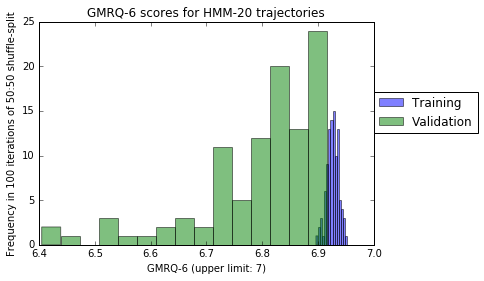

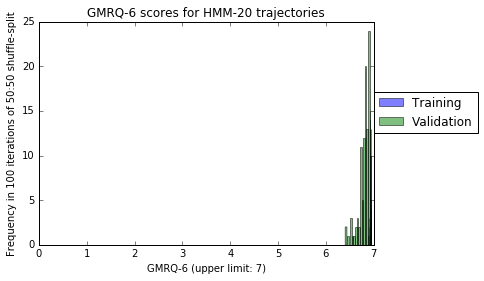

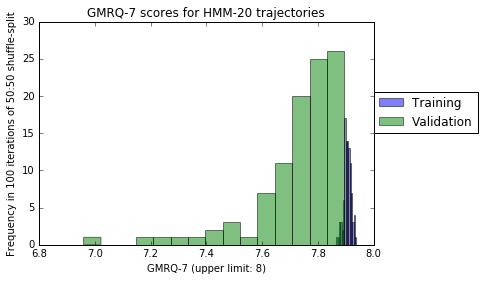

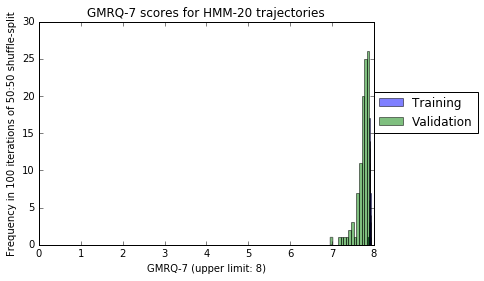

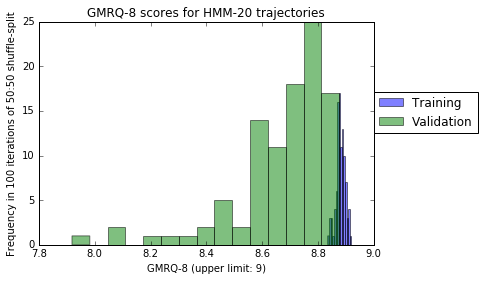

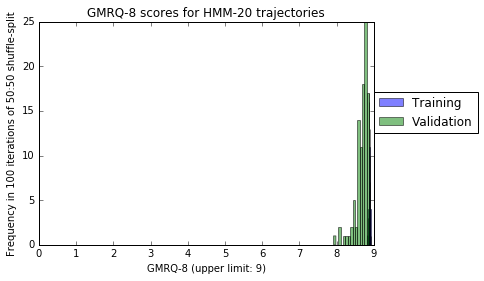

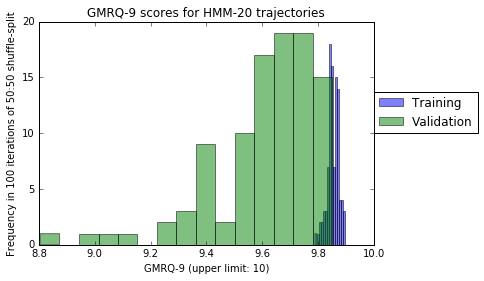

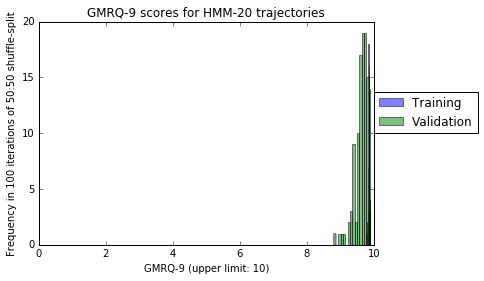

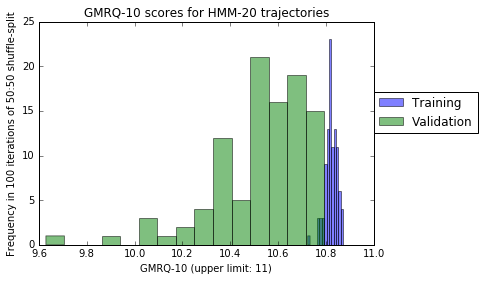

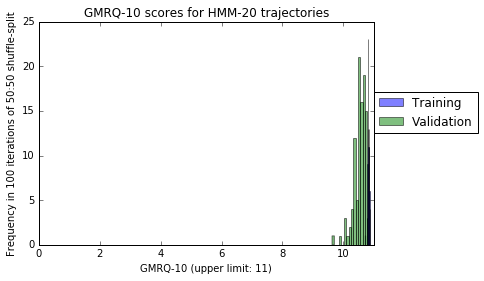

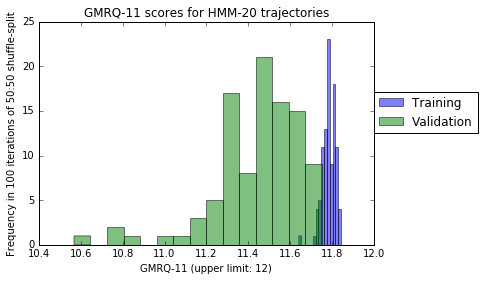

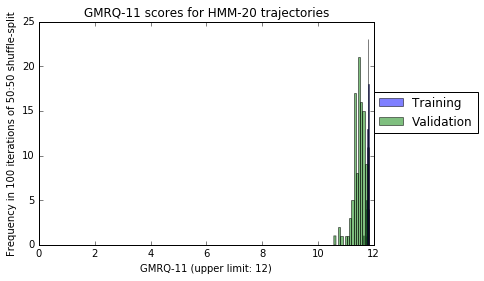

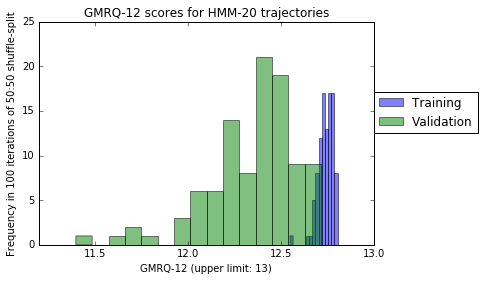

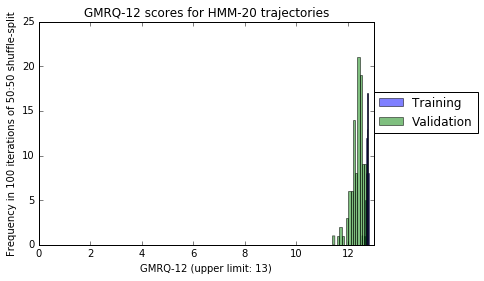

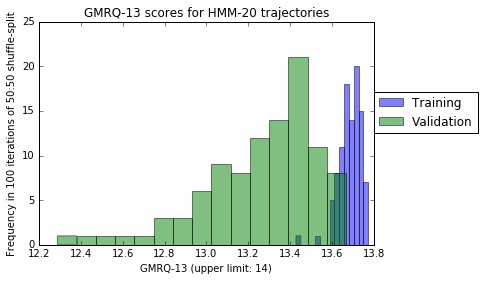

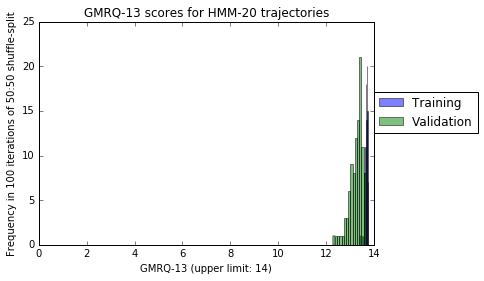

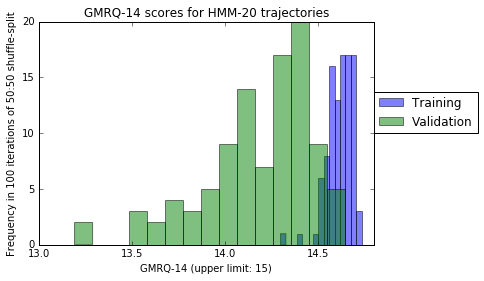

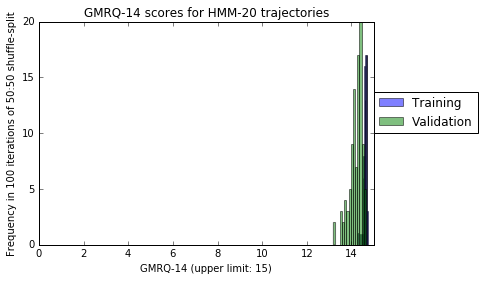

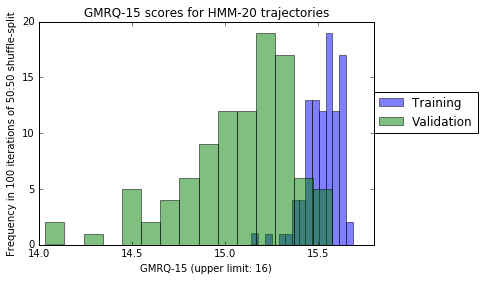

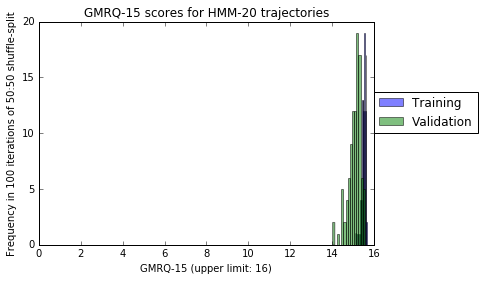

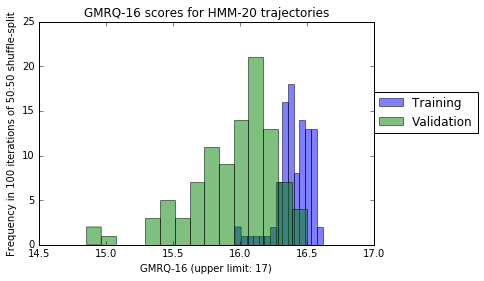

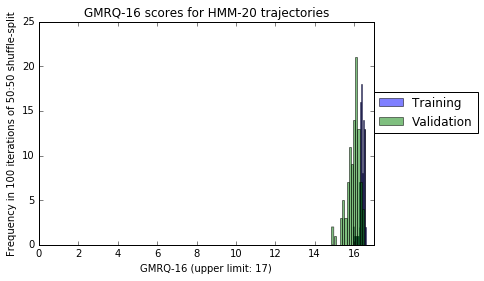

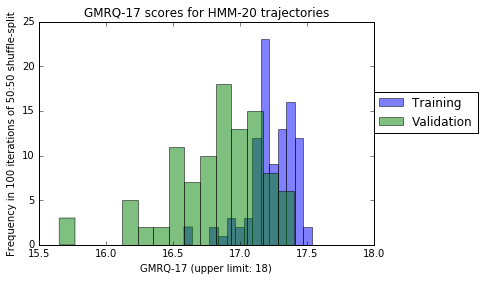

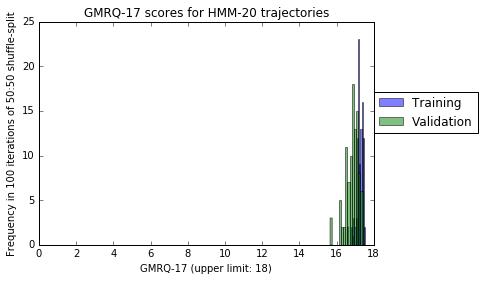

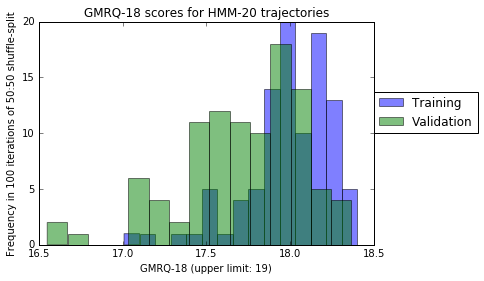

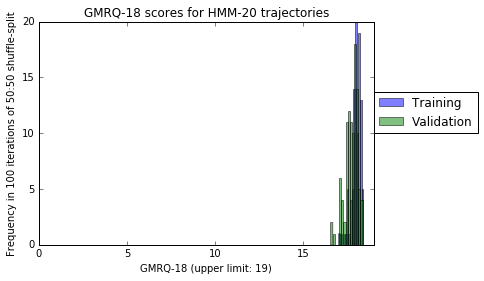

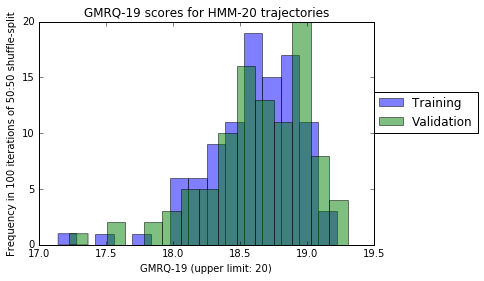

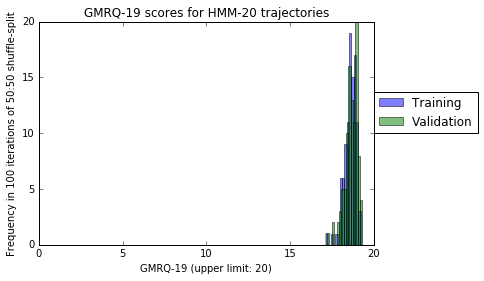

In [11]:
results = dict()

ms = range(1, 20)
for m in ms:
    train_scores, val_scores = shuffle_split_gmrq(cg_dtrajs, m, 50)
    
    plot(train_scores, val_scores, m, 'HMM-20')
    
    results[m] = (train_scores, val_scores)

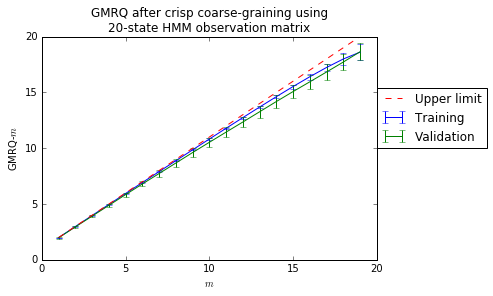

In [12]:
def plot_over_m(results, ms):
    train_means = np.array([np.mean(results[m][0]) for m in ms])
    val_means = np.array([np.mean(results[m][1]) for m in ms])

    train_stderr = np.array([np.std(results[m][0]) for m in ms])
    val_stderr = np.array([np.std(results[m][1]) for m in ms])

    plt.errorbar(ms, train_means, yerr = 1.96 * train_stderr, label='Training')
    plt.errorbar(ms, val_means, yerr = 1.96 * val_stderr, label='Validation')

    plt.plot(ms, np.array(ms)+1, '--', label='Upper limit')
    plt.xlabel(r'$m$')
    plt.ylabel(r'GMRQ-$m$')

    plt.title('GMRQ after crisp coarse-graining using\n20-state HMM observation matrix')

    plt.legend(loc=(1,0.5))
    
plot_over_m(results, ms)

In [13]:
%%time
# what if we do this again, but with more EM iterations?

# let's coarse-grain to 20 states again, but with 5 EM iterations, see if this does anything
hmm_5 = pyemma.msm.estimate_hidden_markov_model(dtrajs, 20, lag=50, maxit=5)

assignments_5 = np.array([crisp_assign_using_hmm(i, hmm_5) for i in range(len(set(np.hstack(dtrajs))))])
cg_dtrajs_5 = [np.array([assignments_5[i] for i in dtraj]) for dtraj in dtrajs]

CPU times: user 1min 38s, sys: 2.67 s, total: 1min 41s
Wall time: 1min 37s


In [17]:
results_5 = dict()

for m in ms:
    train_scores, val_scores = shuffle_split_gmrq(cg_dtrajs_5, m, 50)
    
    # plot(train_scores, val_scores, m, 'HMM-20')
    
    results_5[m] = (train_scores, val_scores)

  2%|▏         | 2/100 [00:00<00:09, 10.67it/s]

('Train scores (mean, stdev):', 1.9938698962158883, 0.001301734699086307)
('Validation scores (mean, stdev):', 1.9923694430782055, 0.002541335173239899)


  2%|▏         | 2/100 [00:00<00:08, 11.76it/s]

('Train scores (mean, stdev):', 2.9852403954638422, 0.0017764403481637131)
('Validation scores (mean, stdev):', 2.9804819157655884, 0.0076463642856852993)


  1%|          | 1/100 [00:00<00:10,  9.45it/s]

('Train scores (mean, stdev):', 3.9740933802360767, 0.0026508709815110457)
('Validation scores (mean, stdev):', 3.9563483924889931, 0.019631176659721715)


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]

('Train scores (mean, stdev):', 4.9604701181266444, 0.0038644235911733508)
('Validation scores (mean, stdev):', 4.9249753008337667, 0.042885907762250118)


  2%|▏         | 2/100 [00:00<00:08, 11.11it/s]

('Train scores (mean, stdev):', 5.9450055159095943, 0.0051589433284822154)
('Validation scores (mean, stdev):', 5.8962153892294706, 0.057837508226050674)


  1%|          | 1/100 [00:00<00:10,  9.72it/s]

('Train scores (mean, stdev):', 6.9271041608604369, 0.0069153044558249704)
('Validation scores (mean, stdev):', 6.8541266628407129, 0.084263787809228552)


  2%|▏         | 2/100 [00:00<00:09, 10.65it/s]

('Train scores (mean, stdev):', 7.9060074913557683, 0.0093285407200952072)
('Validation scores (mean, stdev):', 7.7950693560715081, 0.10485997917461364)


  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]

('Train scores (mean, stdev):', 8.8812637450719869, 0.012302421718542683)
('Validation scores (mean, stdev):', 8.7373035267582573, 0.11728210974166484)


  2%|▏         | 2/100 [00:00<00:08, 11.26it/s]

('Train scores (mean, stdev):', 9.8526685527348885, 0.016341519114695783)
('Validation scores (mean, stdev):', 9.6542379840953476, 0.12898112950928409)


  1%|          | 1/100 [00:00<00:09,  9.92it/s]

('Train scores (mean, stdev):', 10.819463714468259, 0.02142191676730976)
('Validation scores (mean, stdev):', 10.570246297297194, 0.14657833093717593)


  2%|▏         | 2/100 [00:00<00:08, 11.58it/s]

('Train scores (mean, stdev):', 11.780193337015568, 0.027419026267950983)
('Validation scores (mean, stdev):', 11.468665603746508, 0.16301947790170923)


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]

('Train scores (mean, stdev):', 12.733393997590763, 0.034286407107546428)
('Validation scores (mean, stdev):', 12.364821113666833, 0.1886819952789093)


  2%|▏         | 2/100 [00:00<00:08, 11.14it/s]

('Train scores (mean, stdev):', 13.677342485852504, 0.044058446261340034)
('Validation scores (mean, stdev):', 13.259643727940986, 0.22187480092362288)


  2%|▏         | 2/100 [00:00<00:09, 10.59it/s]

('Train scores (mean, stdev):', 14.61101271322832, 0.059010837031951084)
('Validation scores (mean, stdev):', 14.169882377964491, 0.23372869094215229)


  1%|          | 1/100 [00:00<00:10,  9.70it/s]

('Train scores (mean, stdev):', 15.528106569051433, 0.080462654297498229)
('Validation scores (mean, stdev):', 15.078550195884384, 0.25551233036955218)


  1%|          | 1/100 [00:00<00:10,  9.78it/s]

('Train scores (mean, stdev):', 16.418947510167904, 0.11870790666258303)
('Validation scores (mean, stdev):', 15.991411975375167, 0.27854390060094697)


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]

('Train scores (mean, stdev):', 17.269874432861702, 0.17158047253150097)
('Validation scores (mean, stdev):', 16.883273801026679, 0.30478404624926636)


  2%|▏         | 2/100 [00:00<00:09, 10.47it/s]

('Train scores (mean, stdev):', 18.042911866463758, 0.24491565585070749)
('Validation scores (mean, stdev):', 17.800621860536843, 0.32340175869951038)


100%|██████████| 100/100 [00:09<00:00,  9.57it/s]

('Train scores (mean, stdev):', 18.67596181769186, 0.34929654623024109)
('Validation scores (mean, stdev):', 18.736914223455461, 0.33192015631556432)


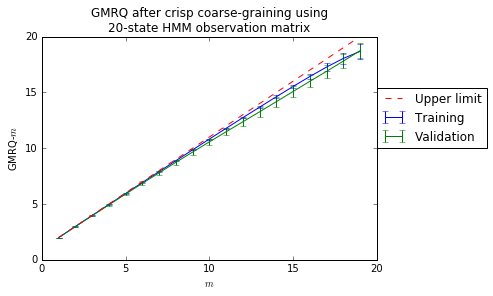

In [18]:
plot_over_m(results_5, ms)

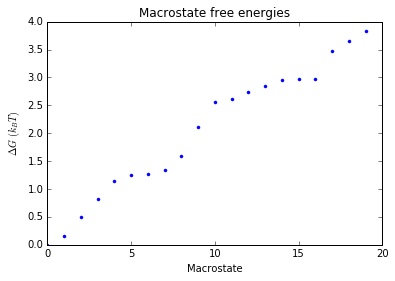

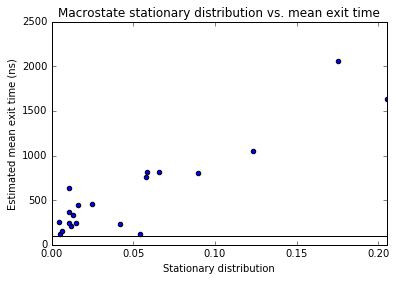

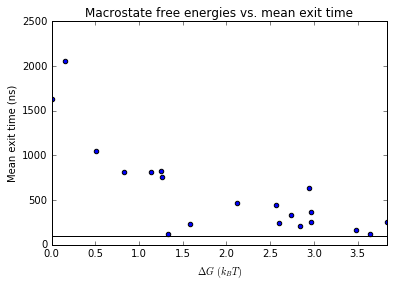

In [25]:
# let's also look at free energies and mean exit times for these crisp partitions

cg_msm = pyemma.msm.estimate_markov_model(cg_dtrajs_5, lag=50)

f_i = -np.log(cg_msm.stationary_distribution)
f_i -= f_i.min()

# free energies
plt.figure()
plt.plot(sorted(f_i), '.')
plt.xlabel('Macrostate')
plt.ylabel(r'$\Delta G$ $(k_B T)$')
plt.title('Macrostate free energies')

def compute_mean_exit_times(msm):
    mean_exit_times = np.zeros(msm.nstates)
    for i in range(msm.nstates):
        not_i = list(set(range(msm.nstates)) - set([i]))
        mean_exit_times[i] = msm.mfpt(i, not_i)
    return mean_exit_times

mean_exit_times = compute_mean_exit_times(cg_msm)

# stationary distribution vs. mean exit times
plt.figure()
plt.scatter(cg_msm.stationary_distribution, (mean_exit_times*0.25))
plt.hlines(100,0,max(cg_msm.stationary_distribution))
plt.xlim(0,max(cg_msm.stationary_distribution))
plt.xlabel('Stationary distribution')
plt.ylabel('Estimated mean exit time (ns)')
plt.title('Macrostate stationary distribution vs. mean exit time')

# free energy vs. mean exit times
plt.figure()
plt.scatter(f_i, (mean_exit_times * 0.25))
plt.hlines(100,0,max(f_i))
plt.xlim(0,max(f_i))
plt.xlabel(r'$\Delta G$ $(k_B T)$')
plt.ylabel('Mean exit time (ns)')
plt.title('Macrostate free energies vs. mean exit time')